# Mixture Model (Coffees dataset)

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Load raw data and plot

In [19]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/coffees/FTIR_instant_coffees.csv')
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
1,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705,1,Arabica
2,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559,1,Arabica
3,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201,1,Arabica
4,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584,1,Arabica


In [20]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

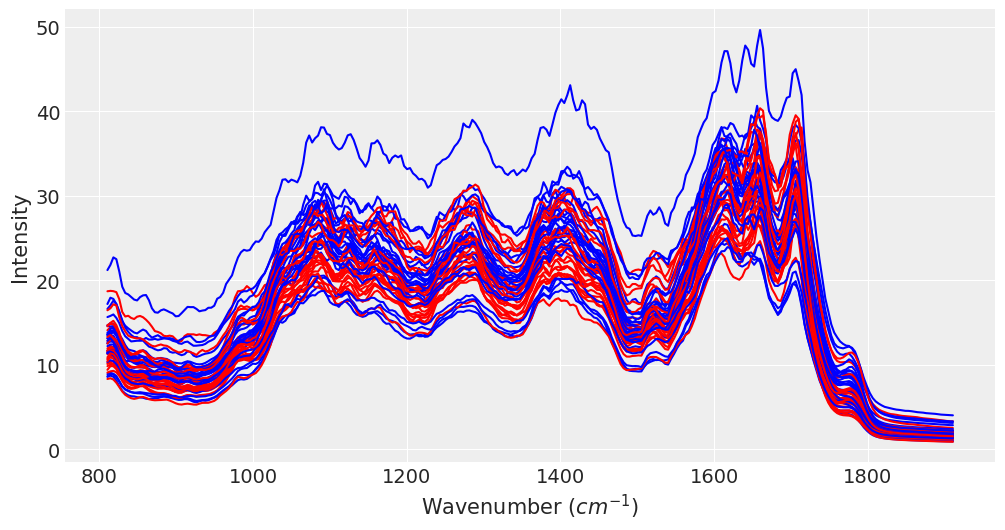

In [21]:
# number of non-data columns at right of dataframe
ndata_cols = -2

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(50):
    y_val = data.values[i]
    if y_val[-1] == 'Arabica':
        col = 'blue'
    else:
        col = 'red'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [22]:
data.describe()

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1879.764,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,12.517039,12.804119,12.818755,12.399288,11.679799,10.900163,10.314007,9.982666,9.795370,9.720186,...,2.005365,1.984751,1.961621,1.941849,1.924347,1.907411,1.892240,1.877957,1.868105,1.482143
std,2.592339,2.647205,2.770784,2.792387,2.658242,2.473864,2.393917,2.365807,2.322628,2.290147,...,0.670579,0.666681,0.660146,0.654320,0.650538,0.646299,0.640707,0.636594,0.636109,0.504203
min,8.343803,8.425415,8.281403,7.897150,7.388507,6.856224,6.469506,6.244600,6.066928,5.987523,...,0.996585,0.982896,0.968990,0.958147,0.947037,0.934733,0.925653,0.918177,0.910757,1.000000
25%,10.876456,11.297045,11.114146,10.726506,10.060188,9.363420,8.873967,8.594105,8.497943,8.347566,...,1.528170,1.509284,1.487934,1.469080,1.455804,1.442437,1.432549,1.423269,1.416944,1.000000
50%,12.012775,12.209154,12.091644,11.797966,10.979776,10.300371,9.722615,9.405373,9.239794,9.181394,...,1.887434,1.866707,1.845152,1.823356,1.800085,1.784015,1.773952,1.759381,1.747113,1.000000
75%,13.705703,14.098454,14.178216,13.747536,12.993840,12.326382,11.570911,11.106771,10.799499,10.850232,...,2.246379,2.229140,2.210848,2.187627,2.167062,2.148594,2.139209,2.130836,2.119545,2.000000
max,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.271924,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,2.000000


In [23]:
# number of samples from each class
data['label'].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

# Model definition

The following statistical model is assumed:

\begin{equation}
X_0 \sim \mathcal{N}(\mu,\,\sigma^{2}) \\
X_1 \sim \mathcal{N}(\mu,\,\sigma^{2}) \\
\epsilon \sim |\mathcal{N}(0,\,\sigma^{2}_\sigma)| \\
\theta \sim Beta(1,1) \\
Y \sim Bernoulli(\theta) \\
X = \begin{cases}X_0 + \epsilon & \text{if } Y = 0 \\X_1 + \epsilon & \text{if } Y = 1\end{cases}
\end{equation}

In [24]:
# standardize data
x_n = data.columns[:-2]
x_s = data[x_n].values
#x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(56, 286)

In [25]:
# create array containing the label for each point
Y = data.iloc[:,-2].to_numpy()

Yl = np.full((len(x_s), len(x_n)), 0)
for i in range(len(x_s)):
    if (Y[i] == 1):
        Yl[i,:] = 1
    else:
        Yl[i,:] = 0

In [26]:
with pm.Model() as model_mm:
    # the modelled spectrum is a (1 x N) row vector of Gaussians
    x_0 = pm.Normal('x_0', mu=x_s.mean(), sd=10, shape=len(x_n))
    x_1 = pm.Normal('x_1', mu=x_s.mean(), sd=10, shape=len(x_n))
    
    # labels 0 or 1 (observed from the data)
    theta = pm.Beta('theta', 1, 1)
    label = pm.Bernoulli('label', p=theta, observed=Yl) 
    
    # switch to spectrum 0 or 1 depending on the label
    x_ = pm.math.switch(pm.math.eq(label, 1), x_0, x_1)
    
    # random noise on top of observation
    epsilon = pm.HalfNormal('epsilon', 1)
    
    x_pred = pm.Normal('x_pred', mu=x_, sd=epsilon, observed=x_s)
    
    trace_mm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, theta, x_1, x_0]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:06<00:00, 75.61draws/s] 


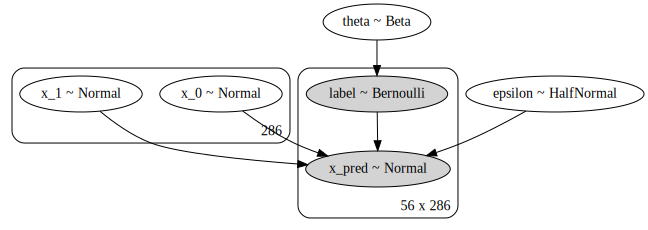

In [27]:
pm.model_to_graphviz(model_mm)

In [28]:
az.summary(trace_mm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x_0[0],13.045,0.626,11.857,14.197,0.006,0.005,9396.0,9396.0,9396.0,2342.0,1.0
x_0[1],13.328,0.601,12.219,14.479,0.006,0.004,9088.0,9032.0,9102.0,2381.0,1.0
x_0[2],13.389,0.616,12.183,14.469,0.006,0.005,9007.0,8912.0,8970.0,2385.0,1.0
x_0[3],12.938,0.609,11.790,14.093,0.006,0.004,10475.0,10383.0,10499.0,2380.0,1.0
x_0[4],12.186,0.618,10.958,13.282,0.006,0.004,9729.0,9729.0,9759.0,2747.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
x_1[283],1.750,0.607,0.610,2.860,0.006,0.005,9035.0,7444.0,9033.0,2546.0,1.0
x_1[284],1.735,0.608,0.585,2.849,0.006,0.005,9383.0,7553.0,9276.0,3004.0,1.0
x_1[285],1.727,0.644,0.503,2.940,0.007,0.006,8856.0,6460.0,8776.0,2548.0,1.0
theta,0.518,0.004,0.511,0.525,0.000,0.000,9963.0,9940.0,9893.0,2765.0,1.0


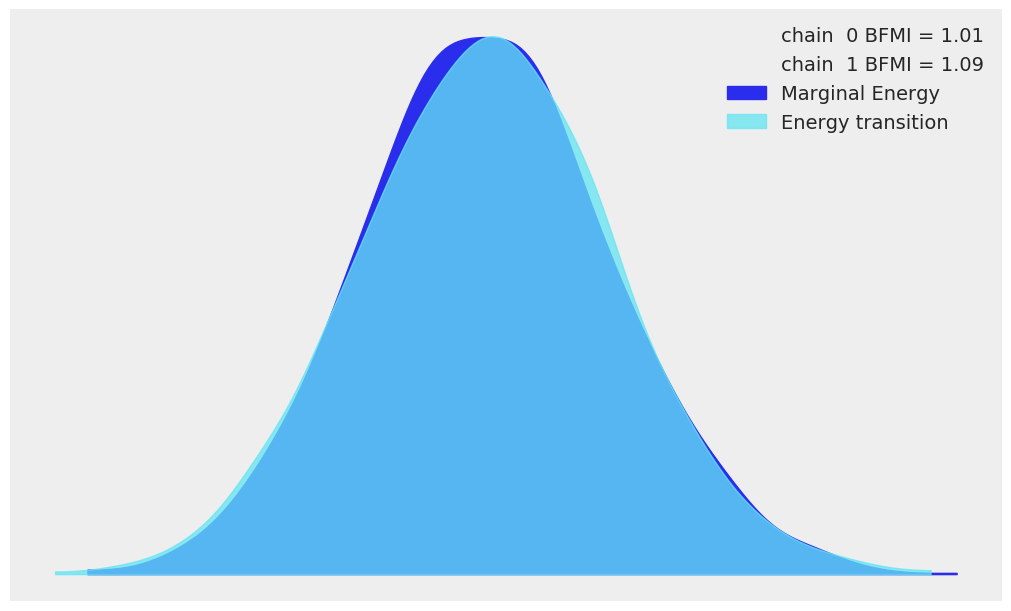

In [29]:
az.plot_energy(trace_mm, figsize=(10, 6));

In [30]:
ppc = pm.sample_posterior_predictive(trace_mm, samples=200, model=model_mm)

100%|██████████| 200/200 [00:00<00:00, 250.35it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


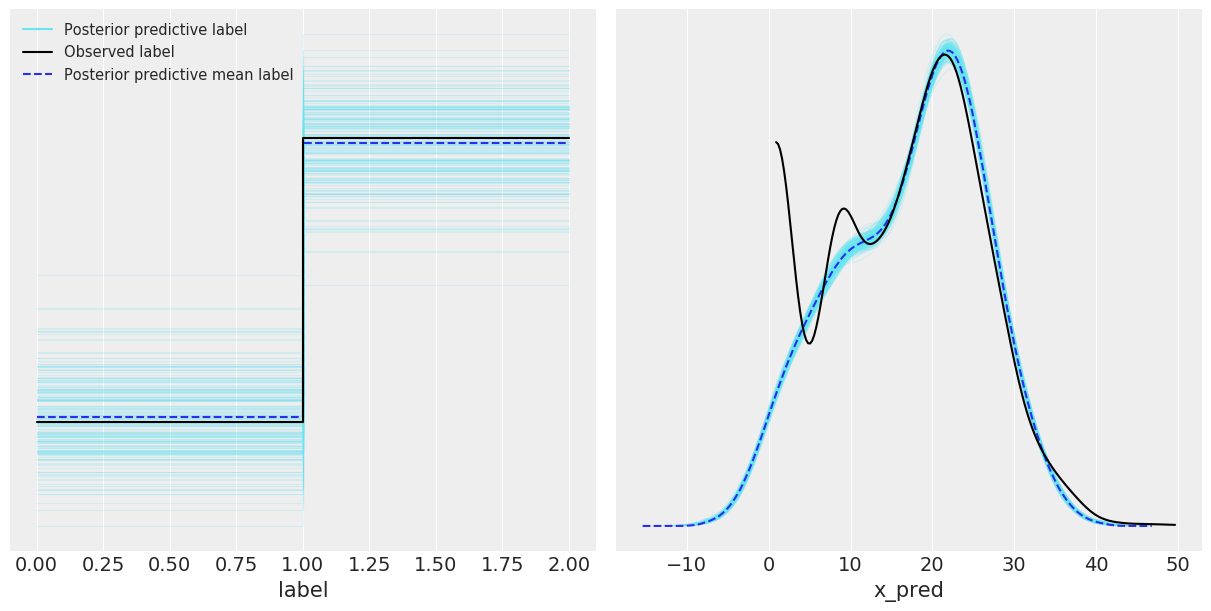

In [31]:
data_ppc = az.from_pymc3(trace=trace_mm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

# Plot of data mean and posterior samples

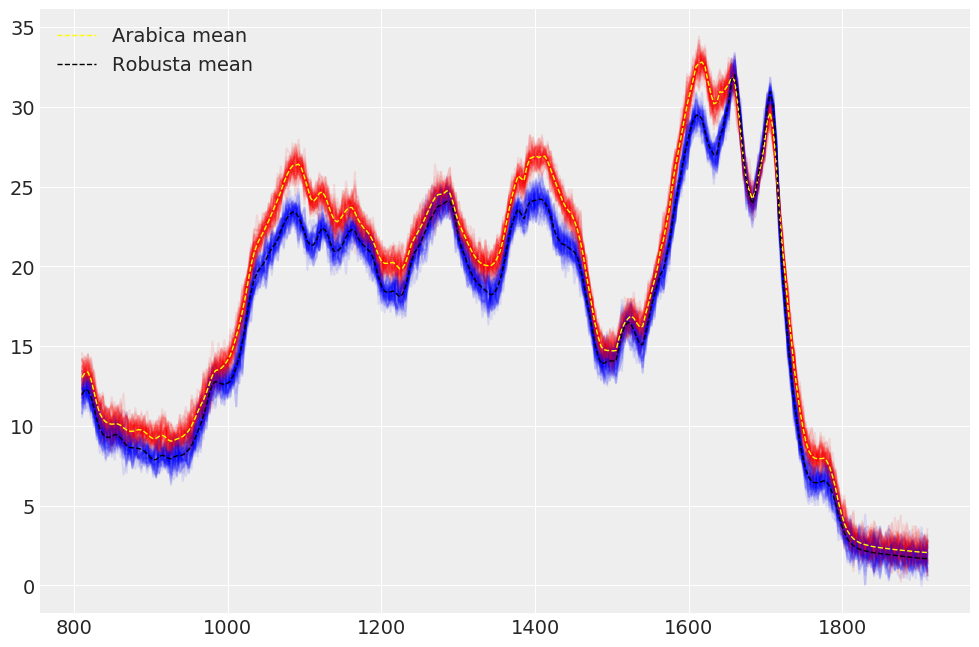

In [32]:
# spectrum samples from the posterior
sp1 = trace_mm['x_0']
sp2 = trace_mm['x_1']

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

for i in range(50):
    plt.plot(x_val, sp1[i], '-', color="red", alpha=0.1)
    plt.plot(x_val, sp2[i], '-', color="blue", alpha=0.1)

# get mean data for labels
df1 = data.loc[data['label'] == 'Arabica']
df2 = data.loc[data['label'] == 'Robusta']

plt.plot(x_val, df1.iloc[:,:-2].mean(), '--', color='yellow', 
         label='Arabica mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:-2].mean(), '--', color='black', 
         label='Robusta mean', linewidth=1)
    
plt.legend(loc='best');

# Real spectrum vs. posterior samples

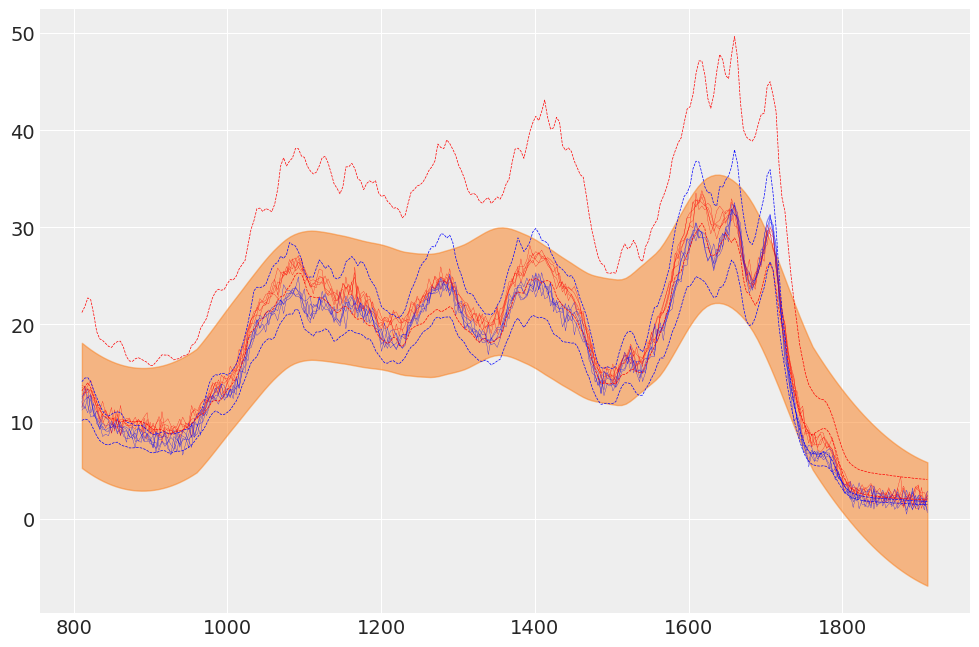

In [33]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

for i in range(5):
    plt.plot(x_val, sp1[i], '-', color="red", linewidth=.2, label='Arabica sample')
    plt.plot(x_val, sp2[i], '-', color="blue", linewidth=.2,  label='Robusta sample')

# get mean data for labels
df1 = data.loc[data['label'] == 'Arabica']
df2 = data.loc[data['label'] == 'Robusta']

for i in range(2):
    plt.plot(x_val, df1.values[i,:-2], '--', color='red', linewidth=.5, label='Arabica real')
    plt.plot(x_val, df2.values[i,:-2], '--', color='blue', linewidth=.5, label='Robusta real')

az.plot_hpd(x_val, ppc['x_pred'], color='C1');